Replication of Ruyi's code.

Dataset: IXI

10% for test, 90% for training. (Option: k-folds cross validation, not implemented yet.)

In [311]:

#to create training.csv and test.csv

import xlrd
import numpy as np
import pandas as pd
import os
import re
from progressbar import *
import nibabel as nib
import pdb
import scipy.ndimage
import matplotlib.pyplot as plt

def IXI_rename():
    '''
    This is an once for all thing.
    rename .nii.gz files as IXI[ixi_id].nii.gz
    '''
    STAMP = False # if any file has the right name for Regular Expression

    target_dir = '/media/woody/Elements/age_data/IXI/IXI-T1'
    files_list = os.listdir(target_dir)
    
    pbar = ProgressBar().start()
    n_bar = len(files_list)
    
    for i,filename in enumerate(files_list):
        re_result = re.match('^IXI.*-.*-.*-T1\.nii\.gz$',filename)
        if re_result:
            STAMP = True
            new_filename = filename.split('-')[0] + '.nii.gz'
            os.rename(os.path.join(target_dir,filename),os.path.join(target_dir,new_filename))
        pbar.update(int(i*100/(n_bar-1)))
    pbar.finish()
    
    if not STAMP:
        print('IXI_rename() finished. No file found.')
    else:
        print('IXI_rename() finished. Done.')
    return

def get_shuffled(imgs, labels):
    temp = np.array([imgs,labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    image_list = list(temp[:,0])
    label_list = list(temp[:,1])
    return image_list,label_list

def gen_phenotypics():
    '''
    This is an once for all thing.
    to generate phenotypics.csv
    '''
    if os.path.exists('./phenotypics.csv'):
        print('phenotypics.csv exists already.')
        return
    # get id and age from .xls
    phenotypic_table = xlrd.open_workbook('IXI.xls','rb')
    pt = phenotypic_table.sheets()[0]

    id_list = pt.col_values(0)[1:]
    index_age = np.where(np.array(pt.row_values(0))=='AGE')[0][0]
    age_list = pt.col_values(index_age)[1:]

    # delete empty items:
    for i in range(len(id_list)-1,0-1,-1):
        if age_list[i] == '':
            del id_list[i]
            del age_list[i]

    # shuffle and save the phenotypic info:
    id_list, age_list = get_shuffled(id_list,age_list)
    data_to_save = pd.DataFrame({'id':id_list,'age':age_list})
    data_to_save.to_csv(os.path.join('./','phenotypics.csv'), index=False, sep=',')
    print('phenotypics.csv created.')
    return

def gen_training_test_csv():
    '''
    This is an once for all thing.
    to generate training.csv and test.csv
    '''
    if os.path.exists('./training.csv') and os.path.exists('./test.csv'):
        print('training.csv and test.csv exist already.')
        return
    phenotypics = pd.read_csv('./phenotypics.csv', sep=',',header=0)
    mid_point = round(0.9 * len(phenotypics))
    training_df = phenotypics[:mid_point]
    test_df = phenotypics[mid_point:]
    training_df.to_csv(os.path.join('./','training.csv'), index=False, sep=',')
    print('training.csv created.')
    test_df.to_csv(os.path.join('./','test.csv'), index=False, sep=',')
    print('test.csv created.')
    return        

def resample(image, pixdim, new_spacing=[1,1,1]):
    '''
    All images are resampled according to the pixel dimension information read from the 
    image header files. 
    This ensures that all images will have the same resolution.
    
    image: ndarray nii_img.get_data()
    pixdim: nii_img.header['pixdim'][1:4]
    
    return: ndarray
    '''
    spacing = pixdim

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
#     new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image

def crop_pad(image,desired_shape):
    '''
    To crop or pad images to the same shape
    
    image: ndarray
    desired_shape: (130,130,110) like tuple
    
    return: ndarray
    '''
    X_margin_0 = int((desired_shape[0]-image.shape[0])/2)
    Y_margin_0 = int((desired_shape[1]-image.shape[1])/2)
    Z_margin_0 = int((desired_shape[2]-image.shape[2])/2)
    
    X_margin_1 = desired_shape[0]-image.shape[0]-X_margin_0
    Y_margin_1 = desired_shape[1]-image.shape[1]-Y_margin_0
    Z_margin_1 = desired_shape[2]-image.shape[2]-Z_margin_0
    
    npad = ((X_margin_0,X_margin_1), 
            (Y_margin_0,Y_margin_1), 
            (Z_margin_0,Z_margin_1))
    crop_padded_img = np.pad(image, pad_width=npad, mode='constant', constant_values=0)
    return crop_padded_img

def preprocess_1(source_dir,target_dir_origin):
    '''
    preprocess using inner_prerpocess_1()
    step.1: resample
    step.2: crop and padd
    
    source_dir = '/media/woody/Elements/age_data/IXI/IXI-T1'
    target_dir_origin = './IXI_npy/origin'
    '''
    nii_list = os.listdir(source_dir)
     
    pbar = ProgressBar().start()
    n_bar = len(nii_list)
    
    for i,filename in enumerate(nii_list):
        re_result = re.match('^IXI[0-9]*\.nii\.gz$',filename)
        if re_result:
            target_filename = os.path.join(target_dir_origin,filename.split('.')[0])
            if not os.path.exists(target_filename + '.npy'):
                pdb.set_trace()
                cropped_npy = inner_preprocess_1(os.path.join(source_dir,filename))
                np.save(target_filename,cropped_npy)
        pbar.update(int(i*100/(n_bar-1)))
    pbar.finish()
    return

def inner_preprocess_1(nii_file):
    '''
    preprocess
    step.1: resample
    step.2: crop and padd
    
    nii_file: absolute path of .nii.gz file
    
    return: ndarray
    '''
    pdb.set_trace()
    DESIRED_SHAPE=(130, 130, 110)
    
    nii_img = nib.load(nii_file)
    header = nii_img.header
    pixdim = header['pixdim'][1:4]
    npy_img = nii_img.get_data()
#     print('original image shape: ',npy_img.shape)
    resampled_img = resample(npy_img, pixdim, [2,2,2])
#     print('resampled img shape: ',resampled_img.shape)
    crop_padded_img = crop_pad(resampled_img,DESIRED_SHAPE)
#     print('crop and padded img shape: ', crop_padded_img.shape)
    crop_padded_img = np.round(crop_padded_img)
    return crop_padded_img.astype(int)

def preprocess_2(target_dir_origin,target_dir_mean):
    '''
    preprocess
    step.3 subtract mean values
    
    target_dir_origin = './IXI_npy/origin'
    target_dir_mean = './IXI_npy/mean_subtracted'
    '''
    # get the mean values of all the training data first
    mean_npy = calc_mean()
    
    npy_list = os.listdir(target_dir_origin)
    
    pbar = ProgressBar().start()
    n_bar = len(npy_list)
    
    for i,filename in enumerate(npy_list):
        re_result = re.match('^IXI[0-9]*\.npy$',filename)
        if re_result:
            target_filename = os.path.join(target_dir_mean,filename)
            if not os.path.exists(target_filename):
                try:
                    origin_npy = np.load(os.path.join(target_dir_origin,filename))
                except FileNotFoundError:
                    print('No such file: ',npy_filename)
                    continue
                subtracted_npy = origin_npy - mean_npy
                np.save(os.path.join(target_dir_mean,filename.split('.')[0]),subtracted_npy)
        pbar.update(int(i*100/(n_bar-1)))
    pbar.finish()
    
    return

def calc_mean():
    '''
    The mean image of all the training data is computed and is subtracted from all training and test data.
    It is worth noting that the test data does not contribute to the mean image. 
    This is because the training data, and only training data, 
        needs to have zero mean for better training performance.
    
    This code is self-content, which means it sucks and could be polished.
    '''
    if os.path.exists('./IXI_npy/mean_npy.npy'):
        print('./IXI_npy/mean_npy.npy exists already.')
        mean_npy = np.load('./IXI_npy/mean_npy.npy')
        return mean_npy
    
    train_df = pd.read_csv('./training.csv', sep=',',header=0)
    id_list = train_df['id']
    type(id_list[0])
    id_list[0]

#     pdb.set_trace()
    count = 0
    npy_list = []
    for ixi_id in id_list:
        str_id = str(int(ixi_id))
        if ixi_id < 10:
            str_id = '00' + str_id
        elif ixi_id > 9 and ixi_id < 100:
            str_id = '0' + str_id
        npy_filename = 'IXI' + str_id + '.npy'

        try:
            origin_npy = np.load(os.path.join('./IXI_npy/origin/',npy_filename))
        except FileNotFoundError:
            print('No such file: ',npy_filename)
            continue
        npy_list.append(origin_npy)
        count += 1
    print('count = ',count)
    mean_npy = np.mean(npy_list,axis=0)
    mean_npy = np.round(mean_npy)
    mean_npy = mean_npy.astype(int)
    np.save(os.path.join('./IXI_npy/','mean_npy'),mean_npy)
    return mean_npy
    
    
    
def gen_npy():
    '''
    To read in .nii.gz files and preprocess, including preprocess_1() and preprocess_2(), 
    then output .npy files in target_dir folder.
    
    '''
    source_dir = '/media/woody/Elements/age_data/IXI/IXI-T1'
    target_dir = './IXI_npy'
    target_dir_origin = os.path.join(target_dir,'origin')
    target_dir_mean = os.path.join(target_dir,'mean_subtracted')
        
    dirs = [target_dir, target_dir_origin,target_dir_mean]
        
    for path in dirs:
        try:
            os.mkdir(path)
        except FileExistsError:
            print(path,' exists already!')
        
    
    # preprocess_1: step.1 step.2   
    preprocess_1(source_dir,target_dir_origin)
    
    # preprocess_2: step.3
    preprocess_2(target_dir_origin,target_dir_mean)

# calc_mean()


# assignment of training and test set
# preprocess each .nii file to .npy and save the location to training.csv/test.csv


# np.array(age_list)==

# print(type(pt.row_values(1)[-1]))
# print(pt.row_values(1)[-1]=='')
# # # pt.row_values(2)
# # # pt.col_values(0)
# index_available = np.where(np.array(pt.row_values(0))=='AGE')[0][0]

# a = np.random.randn(5,5)
# # print(a != '')
# b = np.delete(a,[0,2],0)
# print(b)



In [312]:

# main

# after tar IXI dataset
# rename files
IXI_rename()
# get phenotypics.csv
gen_phenotypics()
# get training.csv test.csv
gen_training_test_csv()
# get preprocessed .npy files
gen_npy()

| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00


IXI_rename() finished. No file found.
phenotypics.csv exists already.
training.csv and test.csv exist already.
./IXI_npy  exists already!
./IXI_npy/origin  exists already!
./IXI_npy/mean_subtracted  exists already!
./IXI_npy/mean_npy.npy exists already.


(130, 130, 110)


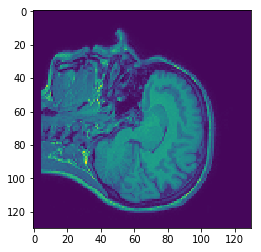

In [321]:
npy_img = np.load('./IXI_npy/mean_npy.npy')
npy_img = np.load('./IXI_npy/mean_subtracted/IXI002.npy')
npy_img = np.load('./IXI_npy/origin/IXI002.npy')
print(npy_img.shape)
plt.imshow(npy_img[:,:,60])
# plt.imshow(npy_img[:,60,:])
# plt.imshow(npy_img[60,:,:])

(130, 130, 110)


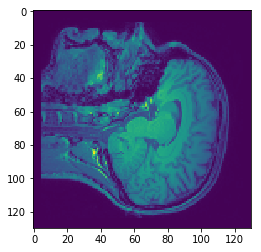

In [322]:
npy_img = np.load('./IXI_npy/origin/IXI012.npy')
print(npy_img.shape)
plt.imshow(npy_img[:,:,60])
# plt.imshow(npy_img[:,60,:])
# plt.imshow(npy_img[60,:,:])

In [298]:
a = np.random.randint(10,size=(3,3))
b = np.random.randint(10,size=(3,3))
c = np.random.randn(3,3)
print(c)
# a += 1
# print(a)
cc = c.astype(int)
print(cc.dtype)
# print(c)
# print(c)
# c.astype(int)
# preprocess_1('IXI002-Guys-0828-T1.nii.gz')

[[ 0.64556574 -0.11930629 -0.55652819]
 [-0.45738679 -0.15989128  0.69457218]
 [-0.2875507   0.19856827  0.58267735]]
int64


In [287]:
10/3

3.3333333333333335

In [ ]:
a = np.random.randint

In [193]:
phenotypics = pd.read_csv('./phenotypics.csv', sep=',',header=0)
# print(phenotypics)
phenotypics[5:10]

,age,id
5,68.134155,473.0
6,44.991102,287.0
7,45.295003,588.0
8,62.455852,392.0
9,66.015058,603.0


| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00


IXI_rename() finished. No file found.
phenotypics.csv exists already.
training.csv and test.csv exist already.
./IXI_npy  exists already!
./IXI_npy/origin  exists already!
mean_npy.npy exists already.
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename

In [137]:
!cd /media/woody/Elements/age_data/IXI/IXI-T1/

os.path.exists('/media/woody/Elements/age_data/IXI/IXI-T1/IXI.*-.*-.*-T1\.nii\.gz$')

False

In [159]:
import time
from progressbar import *

# for i in range(10):
#     print('\r'+str((i+1)*100.0/10)+'%',end='',flush=True)
#     time.sleep(0.3)
# print('abc')

pbar = ProgressBar().start()
for i in range(10):
    pbar.update(int(i*100/(10-1)))
    time.sleep(0.8)
pbar.finish()

| |                 #                               | 100 Elapsed Time: 0:00:08


In [178]:
import time
from progressbar import *
total = 100
def dosomework():
    time.sleep(0.01)
widgets = ['Progress: ',Percentage(), ' ', Bar('>'),' ', Timer(),
      ' ', ETA()]
pbar = ProgressBar(widgets=widgets, maxval=total+100).start()
for i in range(total):
    # do something
    pbar.update(i)
    dosomework()
pbar.finish()

Progress: 100% |>>>>>>>>>>>>>>>>>>>>>>>>>| Elapsed Time: 0:00:01 Time:  0:00:01


In [175]:
ProgressBar?

In [161]:
  
import sys, time  
from progressbar import *  
  
total = 1000  
  
def dosomework():  
    time.sleep(0.01)  
pbar = ProgressBar().start()  
for i in range(1000):  
    pbar.update(int((i / (total - 1)) * 100))  
    dosomework()  
pbar.finish()  

| |       #                                         | 100 Elapsed Time: 0:00:10


In [16]:
data = xlrd.open_workbook('IXI.xls','rb')
print('工作表名为：'+ data.sheet_names()[0])
table = data.sheets()[0]
nrows = table.nrows
ncols = table.ncols
print('表格行数为%d,列数为%d'%(nrows,ncols))

#输出每一行的值
# for item in range(table.nrows):
#     print(table.row_values(item))

#获取单元格的值
cell_A1 = table.row(0)[0].value
cell_A2 = table.cell(0,0).value
cell_A3 = table.col(0)[0].value

print(cell_A1)
print(cell_A2)
print(cell_A3)

工作表名为：Table
表格行数为620,列数为12
IXI_ID
IXI_ID
IXI_ID
